### Задание №2


Алиев Даниял

----------------------------------

In [1]:
import numpy as np
from PIL import Image
from numba import njit, prange, set_num_threads
import cv2
import matplotlib.pyplot as plt
import time

set_num_threads(40)

Для проверки работоспособности алгоритма возьмём две картинки: одну с лекции и одну сделанную самостоятельно.

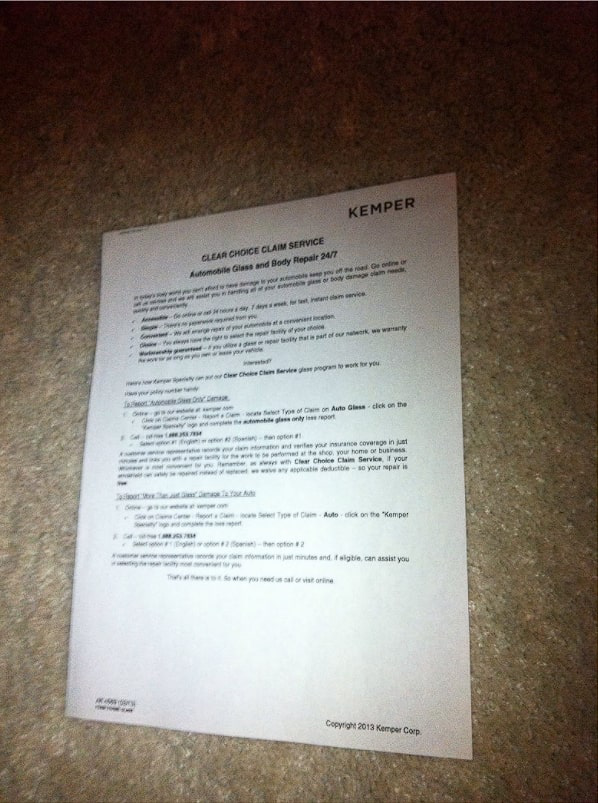

In [2]:
first_image = Image.open("first_image.jpg")
first_image

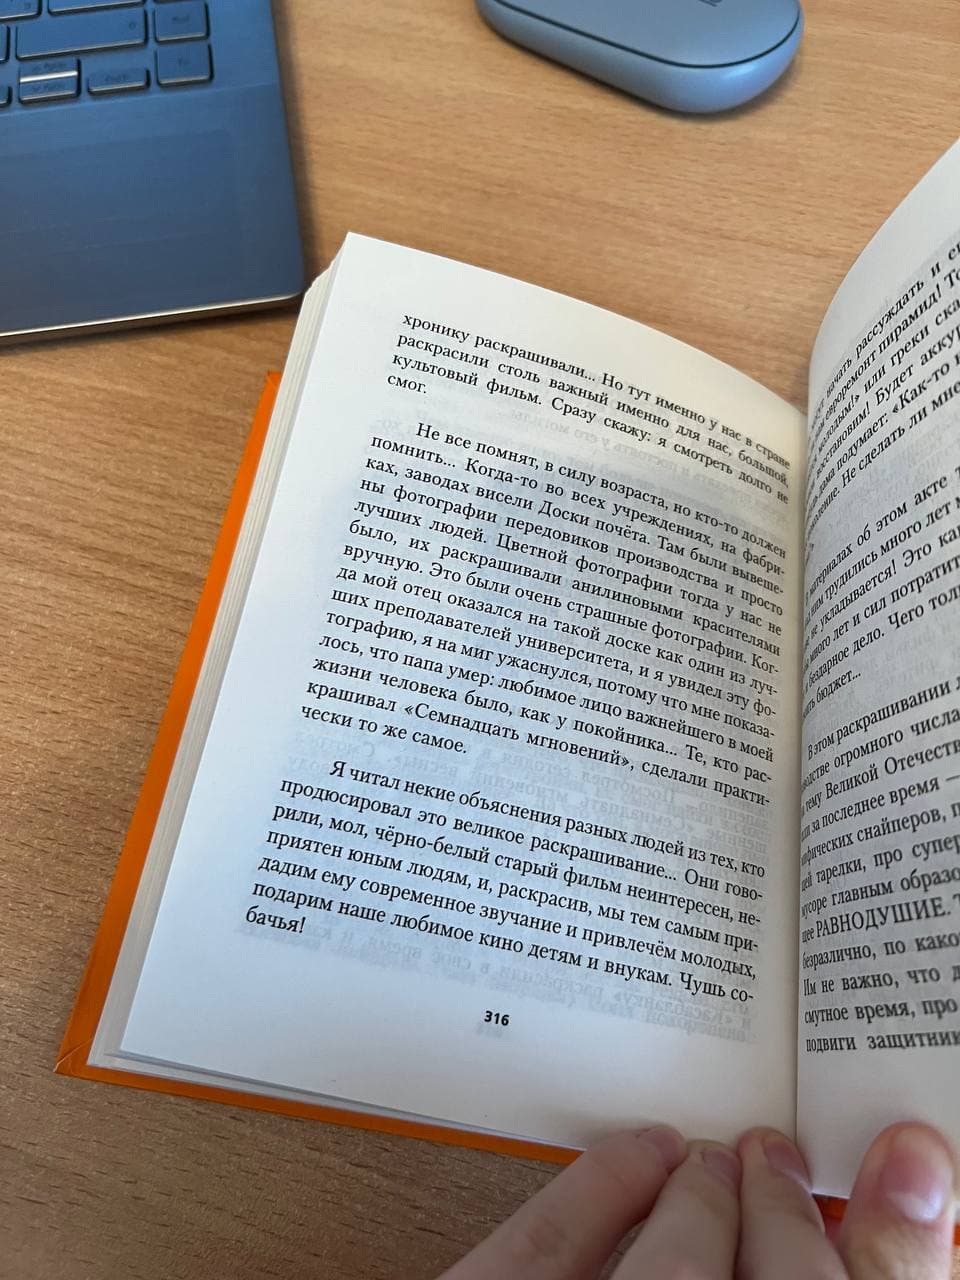

In [3]:
second_image = Image.open("second_image.jpg")
second_image

In [4]:
first_img_np = np.asarray(first_image, dtype=np.uint8)
second_img_np = np.asarray(second_image, dtype=np.uint8)

Так как cv2.medianBlur реализует паддинг replicate, реализуем его:

In [5]:
@njit
def get_padding_image(img, R):
    new_img = np.zeros((img.shape[0] + 2*R, img.shape[1] + 2*R, img.shape[2]), dtype=np.uint8)
    
    for i in prange(img.shape[0] + 2*R):
        for j in prange(img.shape[1] + 2*R):
            new_img[i, j, :] = img[0 if (i < R) else (img.shape[0] - 1 if i >= img.shape[0] + R else i - R), 
                                   0 if (j < R) else (img.shape[1] - 1 if j >= img.shape[1] + R else j - R), :]
            
    return new_img

Асимптотика алгоритмов ниже указана от параметра R. 

В оценку потребляемой памяти не включена память для хранения исходного изображения и результата, так как это не является дополнительной памятью. 

Проверка работоспособности осуществляется сравнением с cv2.medianBlur.

### Первый метод: простая сортировка 

Время работы:  $(O(R^2 log(R))$

Потребляемая память: $O(R^2)$ - для хранения текущего окна

In [6]:
@njit(parallel=True)
def get_median_filter_simple_sort(img, R):
    pad_img = get_padding_image(img, R)
    
    median_filter = np.zeros_like(img)
    
    for i in prange(R, pad_img.shape[0] - R):
        for j in prange(R, pad_img.shape[1] - R):
            window = pad_img[i - R : i + R + 1, j - R :j + R + 1].copy().reshape(-1, 3)
            for row in prange(3):
                window[:, row]=np.sort(window[:, row])
                
            median_filter[i - R, j - R, :] = window[len(window) // 2, :]
            
    return median_filter

Проверим работоспособность:

In [7]:
R = 21

In [8]:
%%time
first_median_filter = get_median_filter_simple_sort(first_img_np, R)

CPU times: user 2min 28s, sys: 4.88 s, total: 2min 32s
Wall time: 7.38 s


In [9]:
%%time
second_median_filter = get_median_filter_simple_sort(second_img_np, R)

CPU times: user 5min 22s, sys: 32.6 ms, total: 5min 22s
Wall time: 9.38 s
Compiler : 100 ms


In [10]:
assert np.all(first_median_filter == cv2.medianBlur(first_img_np, 2 * R + 1))
assert np.all(second_median_filter == cv2.medianBlur(second_img_np, 2 * R + 1))

### Второй метод: Huang et al. 

Время работы: $(O(R))$

Потребляемая память: $O(N)$, где $N$ - количество каналов - для хренения гистограммы

In [11]:
@njit
def get_histogram_median(histogram):
    cumsum = np.cumsum(histogram.reshape(-1))
    all_count = cumsum[-1]
    
    for i in range(len(cumsum)):
        if cumsum[i] >= all_count // 2 + 1:
            return i

@njit(parallel=True)
def get_median_filter_huang(img, R):
    pad_img = get_padding_image(img, R)
    median_filter = np.zeros_like(img)
    
    for i in prange(R, pad_img.shape[0] - R):
        for row in prange(3):
            histogram = np.histogram(pad_img[i - R : i + R + 1, :2 * R + 1, row], bins = 256, range = (0, 255))[0]
        
            for j in prange(R, pad_img.shape[1] - R):
                median_filter[i - R, j - R, row] = get_histogram_median(histogram)
                
                if j != pad_img.shape[1] - R - 1:
                    histogram -= np.histogram(pad_img[i - R : i + R + 1, j - R, row], bins = 256, range = (0, 255))[0]
                    histogram += np.histogram(pad_img[i - R : i + R + 1, j + R + 1, row], bins = 256, range = (0, 255))[0]
            
    return median_filter

Проверим работоспособность:

In [12]:
R = 21

In [13]:
%%time
first_median_filter = get_median_filter_huang(first_img_np, R)

CPU times: user 1min 36s, sys: 28.6 ms, total: 1min 36s
Wall time: 4.78 s


In [14]:
%%time
second_median_filter = get_median_filter_huang(second_img_np, R)

CPU times: user 4min 9s, sys: 47.2 ms, total: 4min 9s
Wall time: 6.85 s


In [15]:
assert np.all(first_median_filter == cv2.medianBlur(first_img_np, 2 * R + 1))
assert np.all(second_median_filter == cv2.medianBlur(second_img_np, 2 * R + 1))

### Третий метод: константный

Время работы: $(O(1))$

Потребляемая память: $O(N * W)$, где $N$ - количество каналов, $W$ - ширина изображения - для хренения гистограмм

In [16]:
@njit
def get_histogram_median(histogram):
    cumsum = np.cumsum(histogram.reshape(-1))
    all_count = cumsum[-1]
    
    for i in range(len(cumsum)):
        if cumsum[i] >= all_count // 2 + 1:
            return i
        
@njit(parallel=True)
def get_median_filter_constant(img, R):
    pad_img = get_padding_image(img, R)
    median_filter = np.zeros_like(img)
    
    for row in prange(3):
        histograms = []
        histograms.append(np.histogram(pad_img[:2 * R + 1, :2 * R + 1, row], bins = 256, range = (0, 255))[0])
        for j in prange(R, pad_img.shape[1] - R - 1):
            next_hist = histograms[-1] - np.histogram(pad_img[:2 * R + 1, j - R, row], bins = 256, range = (0, 255))[0] +\
                                         np.histogram(pad_img[:2 * R + 1, j + R + 1, row], bins = 256, range = (0, 255))[0]
            
            histograms.append(next_hist)
            
        for i in prange(R, pad_img.shape[0] - R):
            for j in prange(R, pad_img.shape[1] - R):
                median_filter[i - R, j - R, row] = get_histogram_median(histograms[j - R])
                    
                if i != pad_img.shape[0] - R - 1:
                    histograms[j - R] -= np.histogram(pad_img[i - R, j - R : j + R + 1, row], bins = 256, range = (0, 255))[0]
                    histograms[j - R] += np.histogram(pad_img[i + R + 1, j - R : j + R + 1, row], bins = 256, range = (0, 255))[0]
            
    return median_filter

Проверим работоспособность:

In [17]:
R = 21

In [18]:
%%time
first_median_filter = get_median_filter_constant(first_img_np, R)

CPU times: user 9.69 s, sys: 27 µs, total: 9.69 s
Wall time: 4.83 s


In [19]:
%%time
second_median_filter = get_median_filter_constant(second_img_np, R)

CPU times: user 18 s, sys: 7.9 ms, total: 18 s
Wall time: 6.41 s


In [20]:
assert np.all(first_median_filter == cv2.medianBlur(first_img_np, 2 * R + 1))
assert np.all(second_median_filter == cv2.medianBlur(second_img_np, 2 * R + 1))

### Визуализация полученных картинок

Так как методы идентичны, визуализируем медианные фильтры, полученные с помощью последнего алгоритма

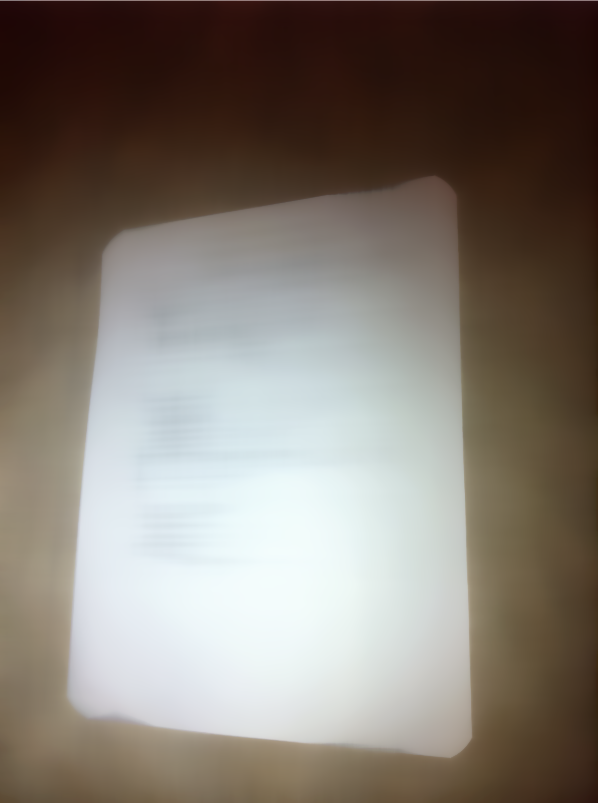

In [21]:
Image.fromarray(first_median_filter)

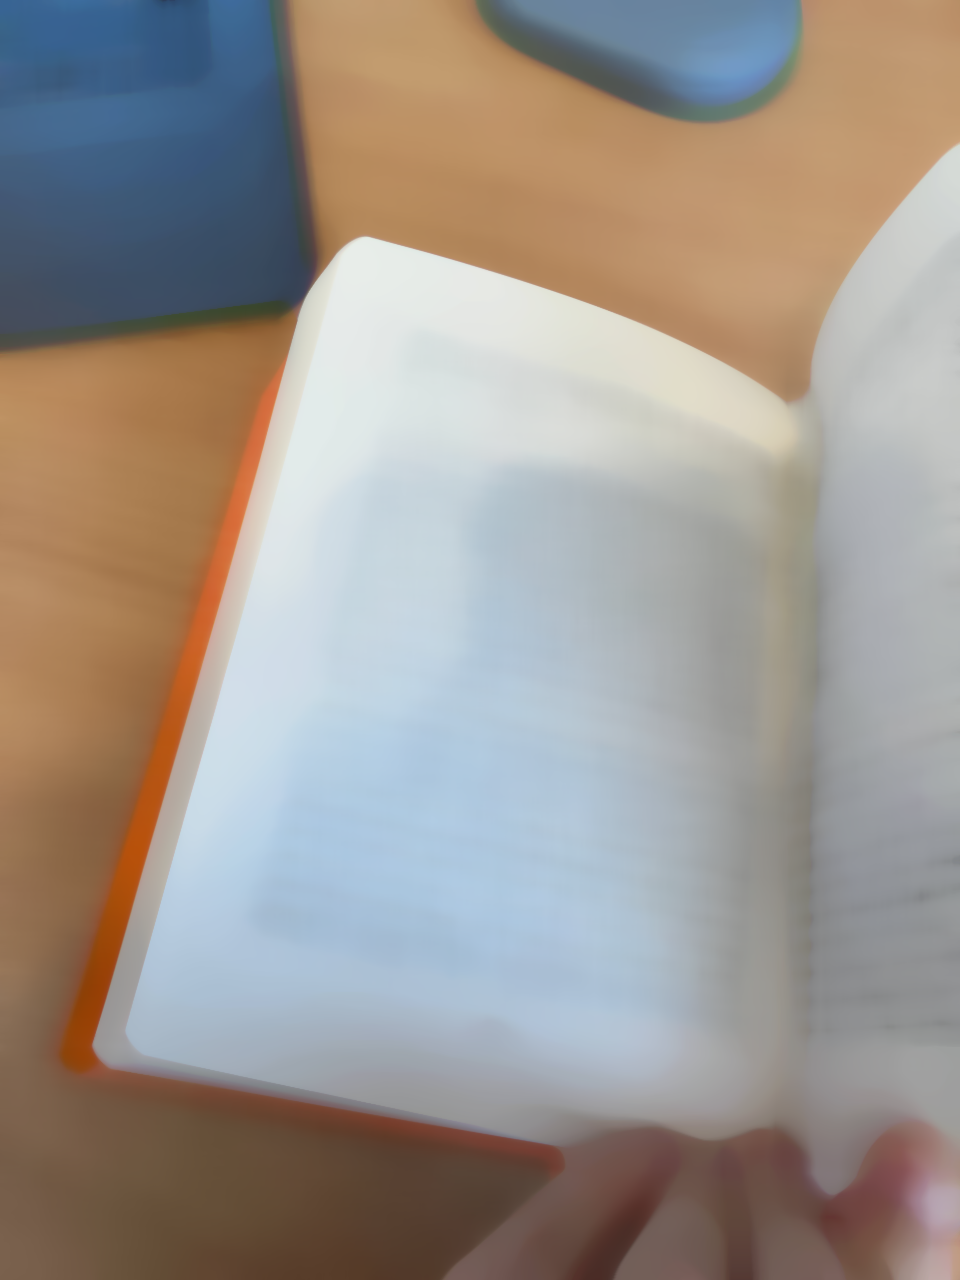

In [22]:
Image.fromarray(second_median_filter)

### Сравнение алгоритмов

Для сравнения алгоритмов по времени будем использовать только первую картинку.

In [23]:
def get_median_filter_time(method, img, R):
    megapixel_count = img.shape[0] * img.shape[1] / 10 ** 6
    start_time = time.time()
    median_filter = method(img, R)
    return (time.time() - start_time) * 1000 / megapixel_count

In [24]:
cv2_time = []
simple_sort_time = []
huang_time = []
constant_time = []

for R in range(1, 100):
    cv2_time.append(get_median_filter_time(cv2.medianBlur, first_img_np, 2 * R + 1))
    simple_sort_time.append(get_median_filter_time(get_median_filter_simple_sort, first_img_np, R))
    huang_time.append(get_median_filter_time(get_median_filter_huang, first_img_np, R))
    constant_time.append(get_median_filter_time(get_median_filter_constant, first_img_np, R))

Text(0.5, 1.0, 'Зависимость времени работы от радиуса окна')

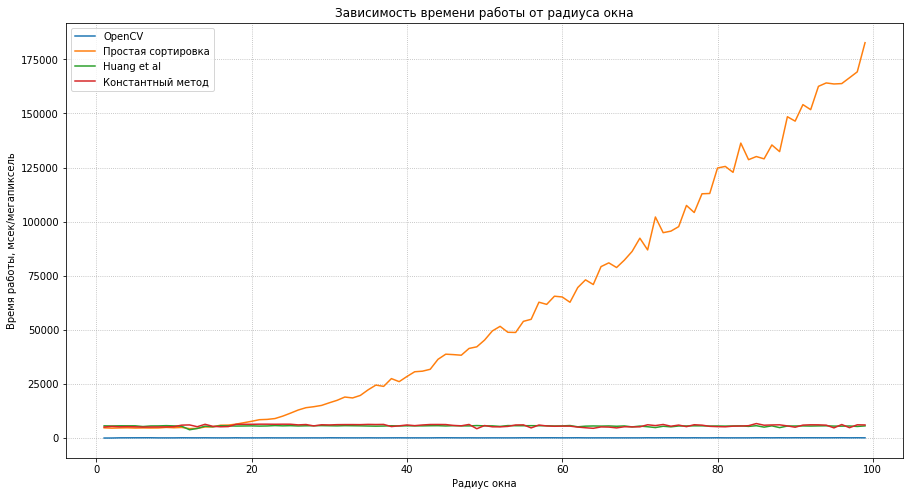

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, 100), cv2_time, label='OpenCV')
plt.plot(np.arange(1, 100), simple_sort_time, label='Простая сортировка')
plt.plot(np.arange(1, 100), huang_time, label='Huang et al')
plt.plot(np.arange(1, 100), constant_time, label='Константный метод')

plt.xlabel('Радиус окна')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.grid(ls=':')
plt.legend()
plt.title('Зависимость времени работы от радиуса окна')

Посмотрим на графики без простой сортировки

Text(0.5, 1.0, 'Зависимость времени работы от радиуса окна')

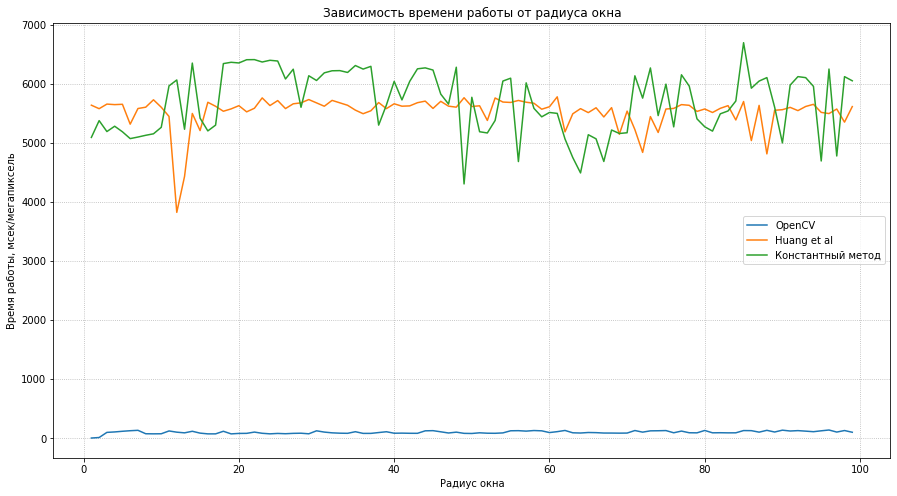

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, 100), cv2_time, label='OpenCV')
plt.plot(np.arange(1, 100), huang_time, label='Huang et al')
plt.plot(np.arange(1, 100), constant_time, label='Константный метод')

plt.xlabel('Радиус окна')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.grid(ls=':')
plt.legend()
plt.title('Зависимость времени работы от радиуса окна')

Ещё посмотрим подробнее на значения при $R \leq 20$:

Text(0.5, 1.0, 'Зависимость времени работы от радиуса окна')

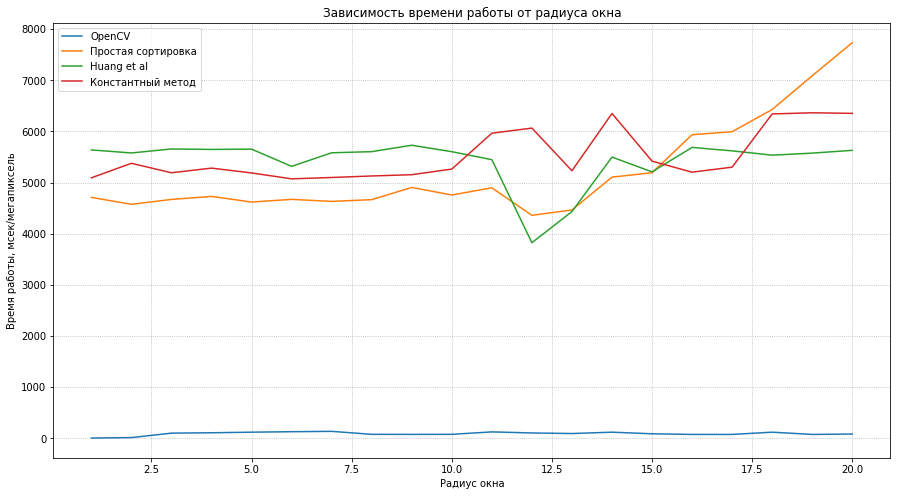

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, 21), cv2_time[:20], label='OpenCV')
plt.plot(np.arange(1, 21), simple_sort_time[:20], label='Простая сортировка')
plt.plot(np.arange(1, 21), huang_time[:20], label='Huang et al')
plt.plot(np.arange(1, 21), constant_time[:20], label='Константный метод')

plt.xlabel('Радиус окна')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.grid(ls=':')
plt.legend()
plt.title('Зависимость времени работы от радиуса окна')

***Вывод:***

До R=15 выгоднее использовать алгоритм простой сортировки, далее - Huang et al.
А вообще лучше всего себя показывает функция из библиотеки OpenCV.

Скорее всего, константный метод достаточно плохо себя показал (относительно своей асимптотики) из-за узкой картинки и использования list.